# Flagging

Demonstration of prototype ngCASA flagging functions built from the CNGI infrastructure.

This walkthrough is designed to be run in a Jupyter notebook on Google Colaboratory. To open the notebook in colab, go [here](https://colab.research.google.com/github/casangi/cngi_prototype/blob/master/docs/flagging.ipynb)


## Installation

In [1]:
import os
print("installing casa6 + cngi (takes a minute or two)...")
os.system("apt-get install libgfortran3")
os.system("pip install --index-url https://casa-pip.nrao.edu:443/repository/pypi-group/simple casatasks==6.2.0.106")
os.system("pip install --index-url https://casa-pip.nrao.edu:443/repository/pypi-group/simple casadata")
os.system("pip install --extra-index-url https://test.pypi.org/simple/ cngi-prototype==0.1.0rc7")

# Retrieve and extract demonstration datasets
print('retrieving MS tarfiles...')
!gdown -q --id 1N9QSs2Hbhi-BrEHx5PA54WigXt8GGgx1
!tar -xzf sis14_twhya_calibrated_flagged.ms.tar.gz
print('complete')

installing casa6 + cngi (takes a minute or two)...
retrieving MS tarfiles...
complete


## Convert MeasurementSet

In [2]:
from cngi.conversion import convert_ms

zarr_name = 'twhya.vis.zarr' 
mxds = convert_ms('sis14_twhya_calibrated_flagged.ms', outfile=zarr_name) 

Completed ddi 0  process time 21.96 s
Completed subtables  process time 1.08 s
                                                  


In [3]:
from cngi.dio import describe_vis 

# We will be working with the only SPW (xds0) present in this dataset, for simplicity
describe_vis(zarr_name)

,spw_id,pol_id,times,baselines,chans,pols,size_MB
xds,,,,,,,
xds0,0,0,410,210,384,2,1586


## Flag Summaries
Summaries of flags by different dimensions in a dictionary, similar to the dictionary produce by CASA flagdata in 'summary' mode.

In [4]:
from ngcasa.flagging import summary

# <temporary> prepare for summaries
mxds.xds0['presence_baseline'] = mxds.xds0.DATA.notnull().any(['chan', 'pol'])
# </temporary>

# Get the initial flagging status
counts = summary(mxds, 0)
counts

{'antenna': {'DA42': {'flagged': 4560, 'total': 5763072},
  'DA44': {'flagged': 4560, 'total': 6081792},
  'DA45': {'flagged': 4560, 'total': 6067200},
  'DA46': {'flagged': 4560, 'total': 6067200},
  'DA48': {'flagged': 4560, 'total': 6067200},
  'DA49': {'flagged': 4560, 'total': 6067200},
  'DA50': {'flagged': 4560, 'total': 6067200},
  'DV02': {'flagged': 4560, 'total': 6040320},
  'DV05': {'flagged': 4560, 'total': 6040320},
  'DV06': {'flagged': 4560, 'total': 6081792},
  'DV08': {'flagged': 4560, 'total': 6068736},
  'DV10': {'flagged': 4560, 'total': 6054144},
  'DV13': {'flagged': 4560, 'total': 6039552},
  'DV15': {'flagged': 4560, 'total': 6053376},
  'DV16': {'flagged': 4560, 'total': 6081792},
  'DV17': {'flagged': 4560, 'total': 6039552},
  'DV18': {'flagged': 4560, 'total': 6067200},
  'DV19': {'flagged': 0, 'total': 4808448},
  'DV20': {'flagged': 4560, 'total': 4757760},
  'DV22': {'flagged': 4560, 'total': 6053376},
  'DV23': {'flagged': 4560, 'total': 5377536}},
 'ar

## Flag Versions




In [5]:
from ngcasa.flagging import manager_list, manager_add, manager_remove

print('* Printing list of flag variables - checkpoint 0:')
versions = manager_list(mxds.xds0)
print(versions)

vis_flags = manager_add(mxds.xds0, 'FLAG_START', 'flags state at start')
vis_flags = manager_add(vis_flags, 'FLAG_BACKUP', 'backup description')
vis_flags = manager_add(vis_flags, 'FLAG_FINAL', 'backup second descr')

print('* Printing list - checkpoint A:')
versions = manager_list(vis_flags)
print(versions)

vis_flags['FLAG'] = vis_flags['FLAG_BACKUP'] | vis_flags['FLAG_START']

# We can always drop versions that are no longer useful
vis_flags = manager_remove(vis_flags, 'FLAG_START')
vis_flags = manager_remove(vis_flags, 'FLAG_BACKUP')
vis_flags = manager_remove(vis_flags, 'FLAG_FINAL')

print('* Printing list - checkpoint B:')
versions = manager_list(vis_flags)
print(versions)

# FLAG variables as added as regular data variables in the xarray Datasets
# An aditional attribute (flag_variables) are added for bookkeeping
print(vis_flags)

* Printing list of flag variables - checkpoint 0:
  Flag variable name             Description
0               FLAG  Default flags variable
* Printing list - checkpoint A:
  Flag variable name             Description
0               FLAG  Default flags variable
1         FLAG_START    flags state at start
2        FLAG_BACKUP      backup description
3         FLAG_FINAL     backup second descr
* Printing list - checkpoint B:
  Flag variable name             Description
0               FLAG  Default flags variable
<xarray.Dataset>
Dimensions:            (baseline: 210, chan: 384, pol: 2, pol_id: 1, spw_id: 1, time: 410, uvw_index: 3)
Coordinates:
  * baseline           (baseline) int64 0 1 2 3 4 5 ... 204 205 206 207 208 209
  * chan               (chan) float64 3.725e+11 3.725e+11 ... 3.728e+11
    chan_width         (chan) float64 dask.array<chunksize=(32,), meta=np.ndarray>
    effective_bw       (chan) float64 dask.array<chunksize=(32,), meta=np.ndarray>
  * pol                (pol)

## Running flagging methods
A few illustrative examples, trying to cover all the categories of flagging methods.



### Meta-Information Based Methods
Methods based on data selection and/or meta-information. Simple examples with data selection based flagging and unflagging.

In [6]:
from ngcasa.flagging import manual_flag, manual_unflag

vis_dset = manager_add(mxds.xds0, 'FLAG_CHECKPOINT_A', 'after a couple of example manual selections')
vis_dset = manager_add(vis_dset, 'FLAG_MANUAL_SELS', 'after applying a few manual flags')

# unflag one antenna (not present)
vis_partial = manual_unflag(mxds, 0, [{'antenna': 'DV06'}])

# unflag one antenna (present)
vis_partial = manual_unflag(mxds, 0, [{'antenna': 'DV02'}])

# unflag all
vis_unflagged = manual_unflag(mxds, 0, [])

# <tmp> Handle return xds / mxds(use cngi._utils._io.vis_xds_packager?)
mxds_manual = mxds
mxds_manual.xds0['FLAG'] = vis_unflagged['FLAG']
# </tmp>

counts = summary(mxds_manual, 0)
print('\n* Flags after unflagging:')
counts


* Flags after unflagging:


{'antenna': {'DA42': {'flagged': 0, 'total': 5763072},
  'DA44': {'flagged': 0, 'total': 6081792},
  'DA45': {'flagged': 0, 'total': 6067200},
  'DA46': {'flagged': 0, 'total': 6067200},
  'DA48': {'flagged': 0, 'total': 6067200},
  'DA49': {'flagged': 0, 'total': 6067200},
  'DA50': {'flagged': 0, 'total': 6067200},
  'DV02': {'flagged': 0, 'total': 6040320},
  'DV05': {'flagged': 0, 'total': 6040320},
  'DV06': {'flagged': 0, 'total': 6081792},
  'DV08': {'flagged': 0, 'total': 6068736},
  'DV10': {'flagged': 0, 'total': 6054144},
  'DV13': {'flagged': 0, 'total': 6039552},
  'DV15': {'flagged': 0, 'total': 6053376},
  'DV16': {'flagged': 0, 'total': 6081792},
  'DV17': {'flagged': 0, 'total': 6039552},
  'DV18': {'flagged': 0, 'total': 6067200},
  'DV19': {'flagged': 0, 'total': 4808448},
  'DV20': {'flagged': 0, 'total': 4757760},
  'DV22': {'flagged': 0, 'total': 6053376},
  'DV23': {'flagged': 0, 'total': 5377536}},
 'array': {'0': {'flagged': 0, 'total': 61872384}},
 'correlatio

### Command Lists

An example of application of a list of manual flagging commands, resembling use cases from pipelines. An additional required input is the file of flagging commands. Here we use a `.flagonline.txt` file as used in pipelines, where we usually find of the order of 1000s or 10s of thousands of commands. The `.flagonline.txt` is the lion's share of the full list of commands used by pipelines (`.flagcmds.txt`), where the `.flagonline.txt` list of commands is extended with a much shorter list of additional commands that may include a number of summaries, selections based on intent and frequency, the shadow method, etc.

The selection syntax used is the Xarray selection syntax (see examples in the [Visibilities walkthrough ](visibilities.ipynb)), with selection by label `xds.sel(...)`.

In [7]:
# Some examples with selections by time, chan, baseline, pol 

vis_flags_tr = manual_unflag(mxds, 0, [{'time': slice('2011-09-16T15:38:17','2011-10-16T18:39:50')}])
vis_flags = manual_unflag(mxds, 0, [{}])

# Flag time range
vis_flags_tr = manual_flag(mxds, 0, [{'time': slice('2012-11-19T08:44:55.000', '2012-11-19T08:52:55.400')}])
# Flag antenna in time range
vis_flags_ta = manual_flag(mxds, 0, [{'time': slice('2012-11-19T07:37:00.000', '2012-11-19T08:23:52.800'), 'antenna': 'DA46'}])

# Flag two groups of adjacent ~20 chans
vis_flags_chan = manual_flag(mxds, 0, [{'chan': slice(3.7266e11, 3.7271e11)},
                                       {'chan': slice(3.7276e11, 3.728e11)}])

# Flag polarization, by ID
vis_flags_pol = manual_flag(mxds, 0, [{'pol': 9}])

# Flag some baselines, by ID
vis_flags_base = manual_flag(mxds, 0, [{'baseline': [133, 134, 135]}])

vis_flags_ta['FLAG'] |= vis_flags_tr['FLAG'] | vis_flags_chan['FLAG']
vis_flags_manual = manager_add(vis_flags_ta, 'FLAG_MANUAL_LIST', 'after applying list of selection commands', 'FLAG')

# <tmp> Handle return xds / mxds(use cngi._utils._io.vis_xds_packager?)
mxds_manual.xds0['FLAG'] = vis_flags_manual['FLAG']
# </tmp>

print('* Printing list - after flagging:')
versions = manager_list(vis_flags_ta)
print(versions)

print('* Flags after flagging some channels and baselines:')
counts = summary(mxds, 0)
counts

* Printing list - after flagging:
  Flag variable name                                  Description
0               FLAG                       Default flags variable
1  FLAG_CHECKPOINT_A  after a couple of example manual selections
2   FLAG_MANUAL_SELS            after applying a few manual flags
3   FLAG_MANUAL_LIST    after applying list of selection commands
* Flags after flagging some channels and baselines:


{'antenna': {'DA42': {'flagged': 2067312, 'total': 5763072},
  'DA44': {'flagged': 2145912, 'total': 6081792},
  'DA45': {'flagged': 2142340, 'total': 6067200},
  'DA46': {'flagged': 4302260, 'total': 6067200},
  'DA48': {'flagged': 2141760, 'total': 6067200},
  'DA49': {'flagged': 2142340, 'total': 6067200},
  'DA50': {'flagged': 2141760, 'total': 6067200},
  'DV02': {'flagged': 2135180, 'total': 6040320},
  'DV05': {'flagged': 2124160, 'total': 6040320},
  'DV06': {'flagged': 2145912, 'total': 6081792},
  'DV08': {'flagged': 2142716, 'total': 6068736},
  'DV10': {'flagged': 2138564, 'total': 6054144},
  'DV13': {'flagged': 2135572, 'total': 6039552},
  'DV15': {'flagged': 2138376, 'total': 6053376},
  'DV16': {'flagged': 2145912, 'total': 6081792},
  'DV17': {'flagged': 2133832, 'total': 6039552},
  'DV18': {'flagged': 2142340, 'total': 6067200},
  'DV19': {'flagged': 1782008, 'total': 4808448},
  'DV20': {'flagged': 1282400, 'total': 4757760},
  'DV22': {'flagged': 2128516, 'total':

### Auto-flagging methods
An illustrative example using the `auto_clip` method. Other auto-flagging methods such as tfcrop, rflag, and uvbin are not implemented.

In [8]:
from ngcasa.flagging import auto_clip

# vis_dset = manager_add(vis_dset, 'auto_clip_test1', 'after applying clip')
versions = manager_list(vis_dset)
print(versions)

vis_clip = auto_clip(vis_dset, 10, 35)

# <tmp> Handle return xds / mxds (use cngi._utils._io.vis_xds_packager?)
mxds.xds0['FLAG'] = vis_clip['FLAG']
# </tmp>

counts_clip = summary(mxds, 0)
counts_clip

  Flag variable name                                  Description
0               FLAG                       Default flags variable
1  FLAG_CHECKPOINT_A  after a couple of example manual selections
2   FLAG_MANUAL_SELS            after applying a few manual flags
3   FLAG_MANUAL_LIST    after applying list of selection commands


{'antenna': {'DA42': {'flagged': 3574131, 'total': 5763072},
  'DA44': {'flagged': 3446333, 'total': 6081792},
  'DA45': {'flagged': 3600687, 'total': 6067200},
  'DA46': {'flagged': 3591839, 'total': 6067200},
  'DA48': {'flagged': 3750212, 'total': 6067200},
  'DA49': {'flagged': 3552130, 'total': 6067200},
  'DA50': {'flagged': 3744628, 'total': 6067200},
  'DV02': {'flagged': 3518095, 'total': 6040320},
  'DV05': {'flagged': 3594624, 'total': 6040320},
  'DV06': {'flagged': 3691423, 'total': 6081792},
  'DV08': {'flagged': 3341354, 'total': 6068736},
  'DV10': {'flagged': 3488830, 'total': 6054144},
  'DV13': {'flagged': 3557439, 'total': 6039552},
  'DV15': {'flagged': 3194677, 'total': 6053376},
  'DV16': {'flagged': 3657900, 'total': 6081792},
  'DV17': {'flagged': 3673673, 'total': 6039552},
  'DV18': {'flagged': 3381264, 'total': 6067200},
  'DV19': {'flagged': 3012167, 'total': 4808448},
  'DV20': {'flagged': 2815375, 'total': 4757760},
  'DV22': {'flagged': 3204976, 'total':

## Applying Flags

To apply a version of flags on a visibilities dataset, before going on to further processing, the function `cngi.vis.apply_flags` should be applied. Some examples can be found in the [Continuum Imaging Example](imaging/continuum_imaging_example.ipynb) or the [Visibilities walkthrough](visibilities.ipynb). `cngi.vis.apply_flags` sets the flagged data values to NaN. This has the effect that those NaN values are effectively excluded from subsequent CNGI/ngCASA processing. Other components of CNGI and ngCASA, such as imaging, will ignore those NaN values.

* versions of flags:   Flag variable name                                  Description
0               FLAG                       Default flags variable
1  FLAG_CHECKPOINT_A  after a couple of example manual selections
2   FLAG_MANUAL_SELS            after applying a few manual flags
3   FLAG_MANUAL_LIST    after applying list of selection commands


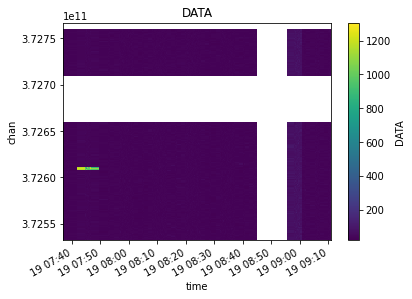

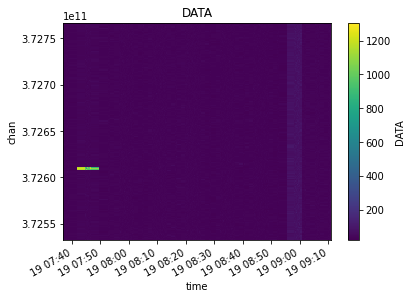

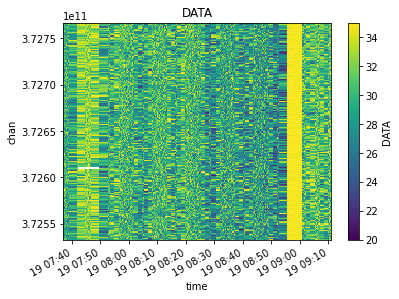

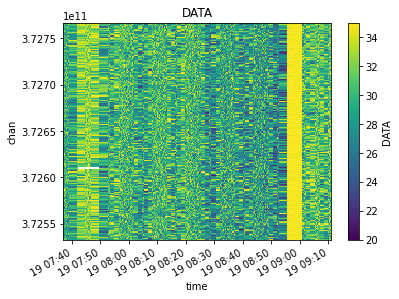

In [9]:
# Further processing: visualization, calibration, imaging, etc. with flags applied (flagged data excluded)
from cngi.vis import apply_flags
from cngi.vis import visplot
from cngi._utils._io import mxds_copier

versions = manager_list(vis_dset)

print(f"* versions of flags: {versions}")
plot_axes = ['time', 'chan']

mxds_manual = mxds.copy()
mxds_manual.attrs['xds0'] = vis_flags_manual

flagged_manual = apply_flags(mxds_manual, 'xds0', flags=['FLAG_MANUAL_LIST'])

visplot(flagged_manual.xds0.DATA, plot_axes)
visplot(mxds.xds0.DATA, plot_axes)

mxds_dset = mxds.copy()
mxds_dset.attrs['xds0'] = vis_dset
mxds_flagged = apply_flags(mxds, 'xds0', flags=['FLAG'])
mxds_clip = mxds.copy()
mxds_clip.attrs['xds0'] = vis_clip
flagged_clip = apply_flags(mxds, 'xds0', flags=['FLAG'])

visplot(mxds_flagged.xds0.DATA, plot_axes)
visplot(flagged_clip.xds0.DATA, plot_axes)